In [1]:
import nibabel as nib
import numpy as np
import pickle

from joblib import Parallel, delayed
from scipy.spatial.distance import dice
from medpy.metric.binary import hd95

In [2]:
idx_dict = {'WM':[2, 41], 'CT':[3, 42], 'LV':[4, 43], 'CW':[7, 46],
            'CC':[251,252,253,254,255], 'TH':[10, 49], 'CA':[11, 50],
            'PU':[12, 51], 'PA':[13, 52], 'BS':[16], 'HP':[17, 53],
            'AM':[18, 54]}

idx_list = [2, 3, 4, 7, 251, 10, 11, 12, 13, 16, 17, 18]
idx_name_list = ['WM', 'CT', 'LV', 'CW', 'CC', 'TH',
                 'CA', 'PU', 'PA', 'BS', 'HP', 'AM']

def process_label(img):
    for item in idx_dict:
        for idx in range(1,len(idx_dict[item])):
            img[img==idx_dict[item][idx]] = idx_dict[item][0]
    return img

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## HA-GAN

In [4]:
root_dir = "/pghbio/dbmi/batmanlab/lisun/pkgs/freesurfer/subjects/"
num_samples = 100
model = "HA_GAN"

In [8]:
def calc_hd(i):
    result = dict()
    if i==86: # Number 86 sample is corrupted
        return result
    real_img = nib.load(root_dir+"x_real_"+str(i)+".nii/mri/aseg.mgz")
    real_img = real_img.get_fdata()
    real_img = process_label(real_img)
    try:
        recon_img = nib.load(root_dir+"x_hat_"+model+"_"+str(i)+".nii/mri/aseg.mgz")
        recon_img = recon_img.get_fdata()
        recon_img = process_label(recon_img)
    except Exception as e:
        print(model, i, "reconstruction failed")
        return dict()
    label_set = set(np.unique(real_img))
    label_set.remove(0)
    #label_set_total = label_set_total.union(label_set)
    for label in label_set:
        if label not in idx_list:
            continue
        real_img_binary = (real_img == label).copy().astype(np.int)
        recon_img_binary = (recon_img == label).copy().astype(np.int)
        try:
            score = hd95(recon_img_binary, real_img_binary)
        except Exception:
            score = -1
        if i not in result:
            result[i] = dict()
        result[i][label] = score
    return result

In [7]:
meta_result = Parallel(n_jobs=28)(delayed(calc_hd)(i) for i in range(num_samples))

In [10]:
result_matrix = np.ones((num_samples, len(idx_list)))

for i in range(num_samples):
    if i==86:
        continue
    for item in meta_result[i][i]:
        result_matrix[i, idx_list.index(item)] = meta_result[i][i][item]
        
result_matrix = np.concatenate([result_matrix[:86,:], result_matrix[87:,:]]) #Num 86 sample is skipped

In [12]:
print("Mean Hausdorff95:", result_matrix.mean())

Mean Hausdorff95: 3.584540226533997


## Alpha_GAN

In [13]:
root_dir = "/pghbio/dbmi/batmanlab/lisun/pkgs/freesurfer/subjects/"
num_samples = 100
model = "Alpha_GAN"

In [14]:
meta_result = Parallel(n_jobs=28)(delayed(calc_hd)(i) for i in range(num_samples))

In [16]:
result_matrix = np.ones((num_samples, len(idx_list)))

for i in range(num_samples):
    if i==86:
        continue
    for item in meta_result[i][i]:
        result_matrix[i, idx_list.index(item)] = meta_result[i][i][item]
        
result_matrix = np.concatenate([result_matrix[:86,:], result_matrix[87:,:]]) #Num 86 sample is skipped

print("Mean Hausdorff95:", result_matrix.mean())

Mean Hausdorff95: 6.055151984948203


## VAE-GAN

In [17]:
root_dir = "/pghbio/dbmi/batmanlab/lisun/pkgs/freesurfer/subjects/"
num_samples = 100
model = "VAE_GAN"

In [18]:
meta_result = Parallel(n_jobs=28)(delayed(calc_hd)(i) for i in range(num_samples))

In [19]:
pickle.dump(meta_result, open( "./results/recon_hd95_small_"+model+".pkl", "wb" ) )
#meta_result = pickle.load(open( "./results/recon_dc_small_"+model+".pkl", "rb" ) )

In [20]:
result_matrix = np.ones((num_samples, len(idx_list)))

for i in range(num_samples):
    if i==86:
        continue
    for item in meta_result[i][i]:
        result_matrix[i, idx_list.index(item)] = meta_result[i][i][item]
        
result_matrix = np.concatenate([result_matrix[:86,:], result_matrix[87:,:]]) #Num 86 sample is skipped

print("Mean Hausdorff95:", result_matrix.mean())

Mean Hausdorff95: 5.869015258986398


In [30]:
result_matrix_pd = pd.DataFrame(data=result_matrix, columns=idx_name_list)
result_matrix_pd['Model']=model
result_matrix_pd.head()

,WM,CT,LV,CW,CC,TH,CA,PU,PA,BS,HP,AM,Model
0,0.613255,0.304320,0.509278,0.666590,0.242015,0.525623,0.310227,0.415053,0.258915,0.678573,0.368489,0.240815,VAE_GAN
1,0.574613,0.264211,0.465233,0.730067,0.168053,0.628524,0.313432,0.489189,0.381626,0.809380,0.330128,0.257928,VAE_GAN
2,0.663194,0.350753,0.483893,0.759407,0.606751,0.753094,0.577498,0.697566,0.717332,0.868807,0.571655,0.698656,VAE_GAN
3,0.635759,0.330399,0.415927,0.800922,0.305294,0.753046,0.571885,0.588992,0.515859,0.844726,0.693712,0.378111,VAE_GAN
4,0.652373,0.338269,0.464974,0.707906,0.412092,0.806826,0.598583,0.589440,0.604779,0.806715,0.657584,0.520129,VAE_GAN


### Summary

In [5]:
import pandas as pd
import seaborn as sns

In [6]:
result_matrix_pd_list = []

for model in ["HA_GAN", "Alpha_GAN", "VAE_GAN"]:
    meta_result = pickle.load(open( "./results/recon_hd95_small_"+model+".pkl", "rb" ) )
    result_matrix = np.ones((num_samples, len(idx_list)))
    for i in range(num_samples):
        if i==86:
            continue
        for item in meta_result[i][i]:
            result_matrix[i, idx_list.index(item)] = meta_result[i][i][item]
    result_matrix = np.concatenate([result_matrix[:86,:], result_matrix[87:,:]]) #Num 86 sample is skipped
    for i in range(len(idx_list)):
        result_matrix_sub = result_matrix[:,i]
        result_matrix_sub_pd = pd.DataFrame(data=result_matrix_sub, columns=['Overlap(Hausdorff95)'])
        result_matrix_sub_pd['Model']=model.replace('_', '-')
        result_matrix_sub_pd['Structure']=idx_name_list[i]
        result_matrix_pd_list.append(result_matrix_sub_pd.copy())

In [7]:
result_matrix_pd_list = pd.concat(result_matrix_pd_list)

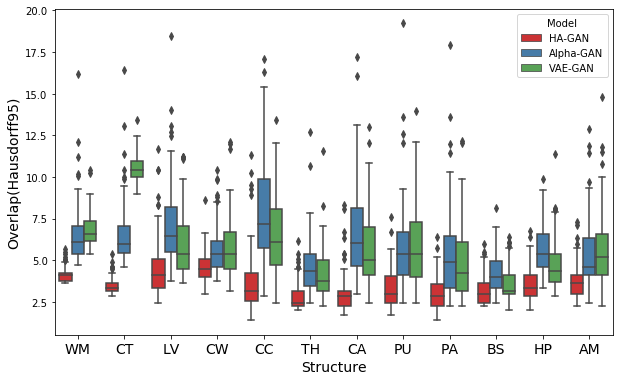

In [9]:
plt.figure(figsize=(10,6))
b=sns.boxplot(x="Structure", y='Overlap(Hausdorff95)', hue="Model", data=result_matrix_pd_list[result_matrix_pd_list['Overlap(Hausdorff95)']<20], palette="Set1")
#sns.plt.show()

b.set_xlabel("Structure",fontsize=14)
b.set_ylabel("Overlap(Hausdorff95)",fontsize=14)
b.set_xticklabels(b.get_xmajorticklabels(), fontsize = 14)
#b.set_yticklabels(b.get_ymajorticklabels(), fontsize = 10)
#sns.plt.show()
plt.savefig("./results/recon_hd95.pdf", bbox_inches='tight')